In [108]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import mplstereonet
from itertools import product
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

In [85]:
def load_bedding_data(filepath):
    """Load bedding data from CSV file"""
    data = pd.read_csv(filepath, sep="\t")
    print("Loaded data shape:", data.shape)
    print("\nFirst few rows:")
    display(data.head())
    return data

In [86]:
def dip_azimuth_to_pole(dip, dip_azimuth):
    """
    Convert dip and dip azimuth to pole (trend and plunge)
    
    Parameters:
    -----------
    dip : float
        Dip angle in degrees
    dip_azimuth : float
        Dip azimuth in degrees
    """
    plunge = 90 - dip
    trend = (dip_azimuth + 180) % 360
    return trend, plunge

def pole_to_vector(trend, plunge):
    """Convert pole (trend, plunge) to 3D unit vector"""
    trend_rad = np.radians(trend)
    plunge_rad = np.radians(plunge)
    
    x = np.cos(plunge_rad) * np.cos(trend_rad)
    y = np.cos(plunge_rad) * np.sin(trend_rad)
    z = np.sin(plunge_rad)
    
    return np.array([x, y, z])

def rotate_vector(vector, rotation_axis, angle_degrees):
    """Rotate a vector around an axis by a given angle"""
    angle_rad = np.radians(angle_degrees)
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
    rot = R.from_rotvec(-angle_rad * rotation_axis)
    return rot.apply(vector)

In [87]:
def unfold_bedding(bedding_vectors, fold_axis, plunge_angle, limb_angle):
    """
    Unfold bedding planes around a fold axis
    
    Parameters:
    -----------
    bedding_vectors : numpy.ndarray
        Array of 3D vectors representing bedding poles
    fold_axis : numpy.ndarray
        3D vector representing the fold axis
    plunge_angle : float
        Plunge removal angle in degrees
    limb_angle : float
        Limb dip removal angle in degrees
    """
    # Step 1: Remove plunge
    horizontal_axis = np.cross(fold_axis, [0, 0, 1])
    horizontal_axis = horizontal_axis / np.linalg.norm(horizontal_axis)
    
    unfolded_vectors = np.array([
        rotate_vector(vector, horizontal_axis, plunge_angle)
        for vector in bedding_vectors
    ])
    
    # Step 2: Remove limb dip
    unfolded_vectors = np.array([
        rotate_vector(vector, fold_axis, limb_angle)
        for vector in unfolded_vectors
    ])
    
    return unfolded_vectors

In [95]:
def calculate_fold_geometry(bedding_data, initial_guess=None, max_iterations=1000, 
                        tolerance=1e-6, step_size=1e-4, disp=True):
    """
    Calculate the geometry of two fold sets using numerical optimization
    
    Parameters:
    -----------
    bedding_data : pandas.DataFrame
        DataFrame containing 'dip' and 'dipAzimuth' columns
    initial_guess : tuple, optional
        Initial guess for (trend1, plunge1, trend2, plunge2)
    max_iterations : int, optional
        Maximum number of iterations for optimization (default: 1000)
    tolerance : float, optional
        Tolerance for convergence (default: 1e-6)
        Smaller values = more accurate but slower
    step_size : float, optional
        Step size for gradient approximation (default: 1e-4)
        Smaller values = more accurate but might be less stable
    disp : bool, optional
        Whether to display optimization progress (default: True)
    """
    # Convert bedding data to vectors
    bedding_vectors = np.array([
        pole_to_vector(*dip_azimuth_to_pole(row['dip'], row['dipAzimuth']))
        for _, row in bedding_data.iterrows()
    ])
    
    if initial_guess is None:
        initial_guess = (0, 0, 90, 0)
        
    def objective_function(params):
        trend1, plunge1, trend2, plunge2 = params
        
        fold_axis1 = pole_to_vector(trend1, plunge1)
        fold_axis2 = pole_to_vector(trend2, plunge2)
        
        unfolded1 = unfold_bedding(bedding_vectors, fold_axis1, plunge1, 45)
        unfolded2 = unfold_bedding(unfolded1, fold_axis2, plunge2, 45)
        
        vertical = np.array([0, 0, 1])
        deviations = np.array([
            np.arccos(np.clip(np.dot(vector, vertical), -1, 1))
            for vector in unfolded2
        ])
        
        return np.var(deviations)
    
    bounds = [(0, 360), (0, 90), (0, 360), (0, 90)]
    
    # Set up optimization options
    options = {
        'maxiter': max_iterations,
        'ftol': tolerance,
        'eps': step_size,
        'disp': disp
    }
    
    result = minimize(objective_function, initial_guess, bounds=bounds, 
                     method='L-BFGS-B', options=options)
    
    if disp:
        print("\nOptimization Results:")
        print(f"Success: {result.success}")
        print(f"Number of iterations: {result.nit}")
        print(f"Final objective value: {result.fun:.6f}")
        print(f"Message: {result.message}")
    
    return [tuple(result.x), (result.fun)]

In [106]:
def plot_stereonet(data, fold_axes=None):
    """Plot bedding data and fold axes on a stereonet"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='stereonet')
    
    # Plot bedding poles
    for _, row in data.iterrows():
        trend, plunge = dip_azimuth_to_pole(row['dip'], row['dipAzimuth'])
        ax.line(plunge, trend, 'k.', markersize=8)
    
    # Plot fold axes if provided
    
    if fold_axes is not None:
        try:
            trend1, plunge1, trend2, plunge2 = fold_axes[0]
            ax.line(plunge1, trend1, 'r^', markersize=12, label='Fold Axis 1')
            ax.line(plunge2, trend2, 'b^', markersize=12, label='Fold Axis 2')
            strike1 = (trend1 + 90) % 360
            strike2 = (trend2 + 90) % 360
            dip1 = 90 - plunge1
            dip2 = 90 - plunge2
            ax.plane(strike1, dip1, 'r-', alpha=0.3, label='Axial Plane 1')
            ax.plane(strike2, dip2, 'b-', alpha=0.3, label='Axial Plane 2')
            plt.legend()
        except:
            trend1, plunge1, trend2, plunge2 = fold_axes
            ax.line(plunge1, trend1, 'r^', markersize=12, label='Fold Axis 1')
            ax.line(plunge2, trend2, 'b^', markersize=12, label='Fold Axis 2')
            strike1 = (trend1 + 90) % 360
            strike2 = (trend2 + 90) % 360
            dip1 = 90 - plunge1
            dip2 = 90 - plunge2
            ax.plane(strike1, dip1, 'r-', alpha=0.3, label='Axial Plane 1')
            ax.plane(strike2, dip2, 'b-', alpha=0.3, label='Axial Plane 2')
            plt.legend()
    
    ax.grid()
    plt.title('Stereonet Plot of Bedding Poles and Fold Axes')
    return fig, ax

Loaded data shape: (360, 20)

First few rows:


,wkt_geom,localityId,localityName,dataId,x,y,latitude,longitude,zone,altitude,horiz_precision,vert_precision,planeType,dip,dipAzimuth,strike,declination,unitId,timedate,notes
0,Point (739389.5399303799495101 4488360.1064380...,d105cbc8ad9120878b0349d998fcf718,15M,5e3ca383fa4399e5975a84f584e25efa,739389.539930,4.488360e+06,40.511435,-6.174508,29T,6.874705,2.346533,-1,Bedding,54.191261,53.104805,323.104797,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:31:44 2024,NaN
1,Point (739393.63094208994880319 4488356.597433...,d105cbc8ad9120878b0349d998fcf718,15M,7688c9c8691bde2c6f12562ea6bc2648,739393.630942,4.488357e+06,40.511403,-6.174461,29T,3.000000,2.386338,-1,Bedding,44.888359,40.487797,310.487793,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:31:33 2024,NaN
2,Point (739500.71842836996074766 4488353.058190...,d105cbc8ad9120878b0349d998fcf718,15M,0b91a3bbce78222902a73cc06127a4c6,739500.718428,4.488353e+06,40.511340,-6.173200,29T,4.092719,4.748652,-1,Bedding,31.894884,47.099674,317.099670,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:25:22 2024,NaN
3,Point (739504.36645005003083497 4488350.739892...,d105cbc8ad9120878b0349d998fcf718,15M,ae8614f2db621e4ae6870d4458308fbe,739504.366450,4.488351e+06,40.511318,-6.173157,29T,3.000000,4.748652,-1,Bedding,32.000000,49.869598,319.869598,-0.25528,Qtz,Fri Aug 30 15:23:40 2024,NaN
4,Point (739498.55154324998147786 4488351.366929...,d105cbc8ad9120878b0349d998fcf718,15M,0052c7504d3e9e3f48e92ce2f9f38554,739498.551543,4.488351e+06,40.511325,-6.173226,29T,3.131712,4.748652,-1,Bedding,26.175228,58.875980,328.875977,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:22:10 2024,NaN



Optimization Results:
Success: True
Number of iterations: 7
Final objective value: 0.033073
Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
[(np.float64(240.97013057595356), np.float64(29.53116427777995), np.float64(186.6320707230223), np.float64(3.8649852252790393)), np.float64(0.033072829189963515)]
Fold Set 1:
Trend: 241.0°
Plunge: 29.5°

Fold Set 2:
Trend: 186.6°
Plunge: 3.9°
Final objective: 0.033072829189963515


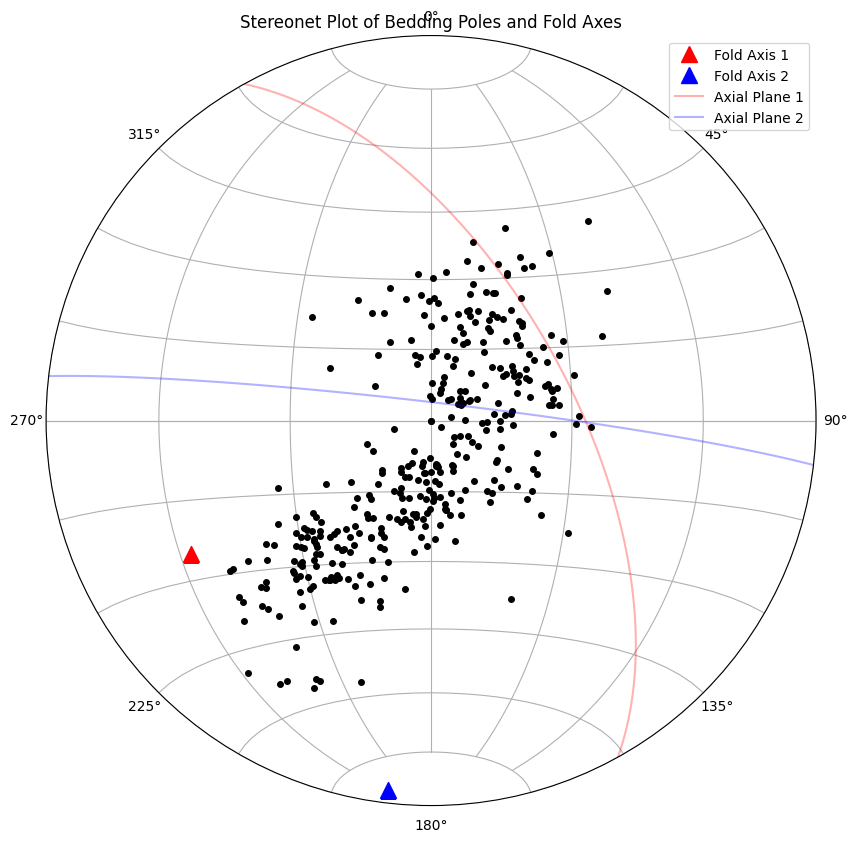

In [111]:
# %%
# Load your data
data = load_bedding_data('pdf.csv')

# Calculate fold geometries
fold_params = calculate_fold_geometry(data, initial_guess=(300, 10, 200, 10), max_iterations=1000, 
                        tolerance=1e-19, step_size=1e-8, disp=True)

print(fold_params)

# Print results

print("Fold Set 1:")
print(f"Trend: {fold_params[0][0]:.1f}°")
print(f"Plunge: {fold_params[0][1]:.1f}°")
print("\nFold Set 2:")
print(f"Trend: {fold_params[0][2]:.1f}°")
print(f"Plunge: {fold_params[0][3]:.1f}°")

print(f"Final objective: {fold_params[1]}")

# Visualize results
plot_stereonet(data, fold_params)
plt.show()


Loaded data shape: (360, 20)

First few rows:


,wkt_geom,localityId,localityName,dataId,x,y,latitude,longitude,zone,altitude,horiz_precision,vert_precision,planeType,dip,dipAzimuth,strike,declination,unitId,timedate,notes
0,Point (739389.5399303799495101 4488360.1064380...,d105cbc8ad9120878b0349d998fcf718,15M,5e3ca383fa4399e5975a84f584e25efa,739389.539930,4.488360e+06,40.511435,-6.174508,29T,6.874705,2.346533,-1,Bedding,54.191261,53.104805,323.104797,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:31:44 2024,NaN
1,Point (739393.63094208994880319 4488356.597433...,d105cbc8ad9120878b0349d998fcf718,15M,7688c9c8691bde2c6f12562ea6bc2648,739393.630942,4.488357e+06,40.511403,-6.174461,29T,3.000000,2.386338,-1,Bedding,44.888359,40.487797,310.487793,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:31:33 2024,NaN
2,Point (739500.71842836996074766 4488353.058190...,d105cbc8ad9120878b0349d998fcf718,15M,0b91a3bbce78222902a73cc06127a4c6,739500.718428,4.488353e+06,40.511340,-6.173200,29T,4.092719,4.748652,-1,Bedding,31.894884,47.099674,317.099670,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:25:22 2024,NaN
3,Point (739504.36645005003083497 4488350.739892...,d105cbc8ad9120878b0349d998fcf718,15M,ae8614f2db621e4ae6870d4458308fbe,739504.366450,4.488351e+06,40.511318,-6.173157,29T,3.000000,4.748652,-1,Bedding,32.000000,49.869598,319.869598,-0.25528,Qtz,Fri Aug 30 15:23:40 2024,NaN
4,Point (739498.55154324998147786 4488351.366929...,d105cbc8ad9120878b0349d998fcf718,15M,0052c7504d3e9e3f48e92ce2f9f38554,739498.551543,4.488351e+06,40.511325,-6.173226,29T,3.131712,4.748652,-1,Bedding,26.175228,58.875980,328.875977,-0.25528,Qtz+Ss+Ms,Fri Aug 30 15:22:10 2024,NaN



Testing 16 different starting points...


Processing starting points: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



Optimization complete:
Successful runs: 16/16
Failed runs: 0/16

Top 5 Solutions (sorted by objective value):
----------------------------------------

Solution 1:
Initial guess: (np.float64(280.0), np.float64(40.0), np.float64(0.0), np.float64(0.0))
Final objective: 0.028440553063179216

Fold Set 1:
Trend: 313.3°
Plunge: 0.0°
Strike: 43.3°
Dip: 90.0°

Fold Set 2:
Trend: 79.4°
Plunge: 1.2°
Strike: 169.4°
Dip: 88.8°

Solution 2:
Initial guess: (np.float64(280.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))
Final objective: 0.028440766834753328

Fold Set 1:
Trend: 329.0°
Plunge: 24.2°
Strike: 59.0°
Dip: 65.8°

Fold Set 2:
Trend: 47.4°
Plunge: 0.5°
Strike: 137.4°
Dip: 89.5°

Solution 3:
Initial guess: (np.float64(340.0), np.float64(40.0), np.float64(0.0), np.float64(0.0))
Final objective: 0.02844202615318366

Fold Set 1:
Trend: 352.8°
Plunge: 42.2°
Strike: 82.8°
Dip: 47.8°

Fold Set 2:
Trend: 34.0°
Plunge: 0.0°
Strike: 124.0°
Dip: 90.0°

Solution 4:
Initial guess: (np.float64(340.

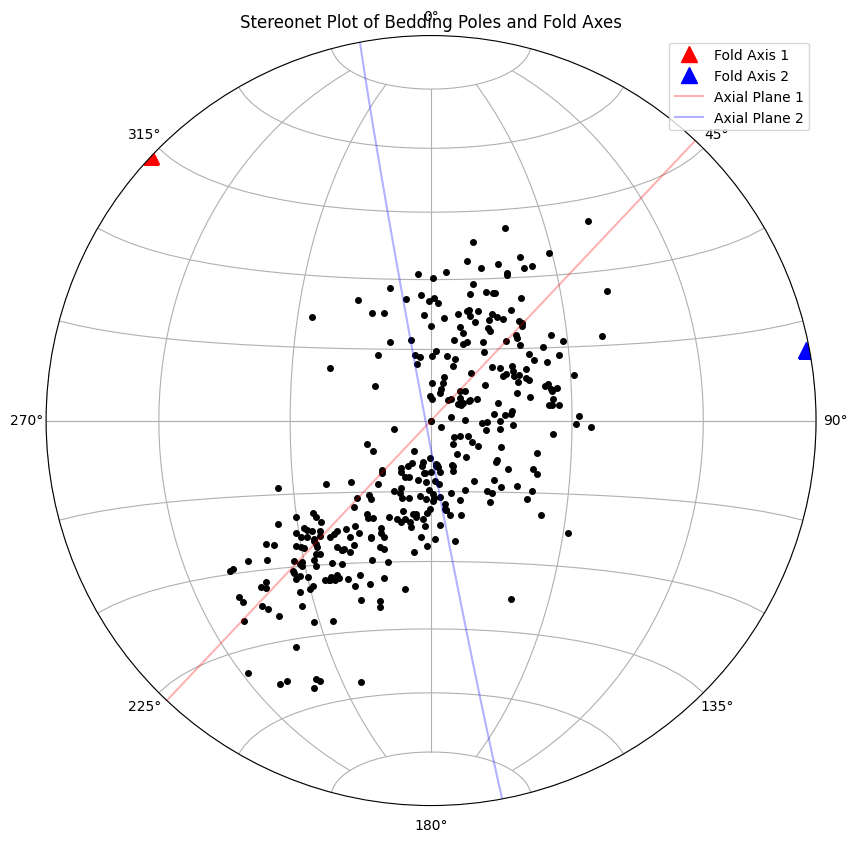

In [120]:
# Load your data
data = load_bedding_data('pdf.csv')

# Define bounds for each parameter
bounds = [(280, 340), (0, 40), (0, 360), (0, 90)]

# Create grid of starting points
n_points = 2  # Number of points to try along each dimension
results = []
failed_count = 0
successful_count = 0

# Generate grid points for initial guesses
grid_points = [np.linspace(start, end, n_points) for start, end in bounds]
all_combinations = list(product(*grid_points))
total_combinations = len(all_combinations)

print(f"\nTesting {total_combinations} different starting points...")

# Try each starting guess with progress bar
for guess in tqdm(all_combinations, desc="Processing starting points"):
    try:
        # Calculate fold geometries with current starting guess
        fold_params = calculate_fold_geometry(data, 
                                           initial_guess=guess, 
                                           max_iterations=1000,
                                           tolerance=1e-19, 
                                           step_size=1e-8, 
                                           disp=False)
        
        results.append({
            'initial_guess': guess,
            'final_params': fold_params[0],  # Parameters are in index 0
            'objective_value': fold_params[1]  # Objective value is in index 1
        })
        successful_count += 1
            
    except Exception as e:
        print(f"\nFailed for guess {guess}: {str(e)}")
        failed_count += 1

# Print summary statistics
print(f"\nOptimization complete:")
print(f"Successful runs: {successful_count}/{total_combinations}")
print(f"Failed runs: {failed_count}/{total_combinations}")

# Only proceed if we have results
if results:
    # Sort results by objective value
    sorted_results = sorted(results, key=lambda x: x['objective_value'])

    # Print best results
    print("\nTop 5 Solutions (sorted by objective value):")
    print("----------------------------------------")
    for i, result in enumerate(sorted_results[:5]):
        print(f"\nSolution {i+1}:")
        print(f"Initial guess: {result['initial_guess']}")
        print(f"Final objective: {result['objective_value']}")
        print("\nFold Set 1:")
        print(f"Trend: {result['final_params'][0]:.1f}°")
        print(f"Plunge: {result['final_params'][1]:.1f}°")
        strike1 = (result['final_params'][0] + 90) % 360
        strike2 = (result['final_params'][2] + 90) % 360
        dip1 = 90 - result['final_params'][1]
        dip2 = 90 - result['final_params'][3]
        print(f"Strike: {strike1:.1f}°")
        print(f"Dip: {dip1:.1f}°")
        print("\nFold Set 2:")
        print(f"Trend: {result['final_params'][2]:.1f}°")
        print(f"Plunge: {result['final_params'][3]:.1f}°")
        print(f"Strike: {strike2:.1f}°")
        print(f"Dip: {dip2:.1f}°")


    # Visualize best result
    plot_stereonet(data, sorted_results[0]['final_params'])
    plt.show()
else:
    print("\nNo successful optimizations to display.")